# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn 

from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist


# magic word for producing visualizations in notebook
%matplotlib inline

plt.rc('figure', max_open_warning = 0)
pd.options.display.max_rows = 200
print (sklearn.__version__)

0.23.2


### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';')

# Load in the feature summary file.
customer_info = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of rows and columns, print the first few rows).
#azdias.head()
#print("Azdias "+ azdias.shape,feat_info.shape, customer_info.shape)
print('Azdias   : ',azdias.shape)
print('Feature  : ',feat_info.shape)
print('Customer : ',customer_info.shape)

Azdias   :  (891221, 85)
Feature  :  (85, 4)
Customer :  (191652, 85)


In [4]:
display(customer_info.head(),customer_info.describe(), customer_info.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Data columns (total 85 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AGER_TYP               191652 non-null  int64  
 1   ALTERSKATEGORIE_GROB   191652 non-null  int64  
 2   ANREDE_KZ              191652 non-null  int64  
 3   CJT_GESAMTTYP          188439 non-null  float64
 4   FINANZ_MINIMALIST      191652 non-null  int64  
 5   FINANZ_SPARER          191652 non-null  int64  
 6   FINANZ_VORSORGER       191652 non-null  int64  
 7   FINANZ_ANLEGER         191652 non-null  int64  
 8   FINANZ_UNAUFFAELLIGER  191652 non-null  int64  
 9   FINANZ_HAUSBAUER       191652 non-null  int64  
 10  FINANZTYP              191652 non-null  int64  
 11  GEBURTSJAHR            191652 non-null  int64  
 12  GFK_URLAUBERTYP        188439 non-null  float64
 13  GREEN_AVANTGARDE       191652 non-null  int64  
 14  HEALTH_TYP             191652 non-nu

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,191652.000000,191652.000000,191652.000000,188439.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,...,138888.000000,138888.000000,138888.000000,138888.000000,138888.000000,138888.000000,138888.000000,141176.000000,141176.000000,141176.000000
mean,0.344359,3.060907,1.376432,3.677928,3.963773,2.057051,4.183317,2.439808,2.646176,2.781176,...,2.537404,2.731510,1.388817,0.539939,1.556607,3.634893,3.622192,2.824850,5.119517,2.898510
std,1.391672,1.086254,0.484492,1.813975,1.036230,1.319422,0.995365,1.697932,1.586506,1.147353,...,0.904927,0.840922,0.885038,0.637048,1.185736,0.933660,1.008472,1.012415,2.159184,1.422683
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,-1.000000,3.000000,1.000000,2.000000,3.000000,1.000000,3.000000,1.000000,1.000000,2.000000,...,2.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,2.000000,4.000000,2.000000
50%,0.000000,3.000000,1.000000,4.000000,4.000000,1.000000,5.000000,2.000000,2.000000,3.000000,...,3.000000,3.000000,1.000000,0.000000,1.000000,3.000000,4.000000,3.000000,5.000000,3.000000
75%,2.000000,4.000000,2.000000,6.000000,5.000000,4.000000,5.000000,5.000000,5.000000,3.000000,...,3.000000,3.000000,2.000000,1.000000,1.000000,4.000000,4.000000,4.000000,7.000000,4.000000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.000000


None

In [5]:
display(azdias.head(), azdias.describe(), azdias.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AGER_TYP               891221 non-null  int64  
 1   ALTERSKATEGORIE_GROB   891221 non-null  int64  
 2   ANREDE_KZ              891221 non-null  int64  
 3   CJT_GESAMTTYP          886367 non-null  float64
 4   FINANZ_MINIMALIST      891221 non-null  int64  
 5   FINANZ_SPARER          891221 non-null  int64  
 6   FINANZ_VORSORGER       891221 non-null  int64  
 7   FINANZ_ANLEGER         891221 non-null  int64  
 8   FINANZ_UNAUFFAELLIGER  891221 non-null  int64  
 9   FINANZ_HAUSBAUER       891221 non-null  int64  
 10  FINANZTYP              891221 non-null  int64  
 11  GEBURTSJAHR            891221 non-null  int64  
 12  GFK_URLAUBERTYP        886367 non-null  float64
 13  GREEN_AVANTGARDE       891221 non-null  int64  
 14  HEALTH_TYP             891221 non-nu

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


None

In [6]:
display(feat_info.head(),feat_info.describe())

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,KBA05_GBZ,person,ordinal,[-1]
freq,1,43,49,26


In [7]:
feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(lambda x: x[1:-1].split(','))

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [8]:
# Identify missing or unknown data values and convert them to NaNs.
for i in range(feat_info.shape[0]):
    azdias.loc[azdias[feat_info.iloc[i,0]].isin(feat_info.iloc[i,-1]), feat_info.iloc[i,0]] =np.nan

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [9]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missingPerColumn = azdias.isnull().sum()
missingPerColumn = missingPerColumn[missingPerColumn.values>0].sort_values(ascending=False)
missingPerColumn

TITEL_KZ                 889061
AGER_TYP                 685843
KK_KUNDENTYP             584612
KBA05_BAUMAX             476524
GEBURTSJAHR              392318
ALTER_HH                 310267
REGIOTYP                 158064
KKK                      158064
W_KEIT_KIND_HH           147988
KBA05_ANTG4              133324
KBA05_GBZ                133324
MOBI_REGIO               133324
KBA05_ANTG1              133324
KBA05_ANTG2              133324
KBA05_ANTG3              133324
PLZ8_GBZ                 116515
PLZ8_HHZ                 116515
PLZ8_BAUMAX              116515
PLZ8_ANTG4               116515
PLZ8_ANTG1               116515
PLZ8_ANTG3               116515
PLZ8_ANTG2               116515
SHOPPER_TYP              111196
VERS_TYP                 111196
HEALTH_TYP               111196
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
KBA13_ANZAHL_PKW         105800
ANZ_HAUSHALTE_AKTIV       99611
CAMEO_INTL_2015           99352
CAMEO_DEU_2015            99352
CAMEO_DE

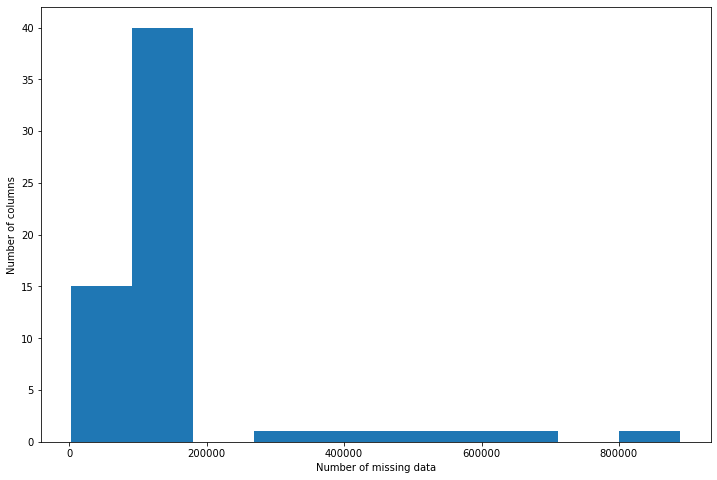

In [10]:
missingData = pd.DataFrame(missingPerColumn)
missingData.columns = ['missing data']
plt.figure(figsize=(12,8))
plt.hist(missingData['missing data'])
plt.ylabel('Number of columns')
plt.xlabel('Number of missing data')
plt.show()

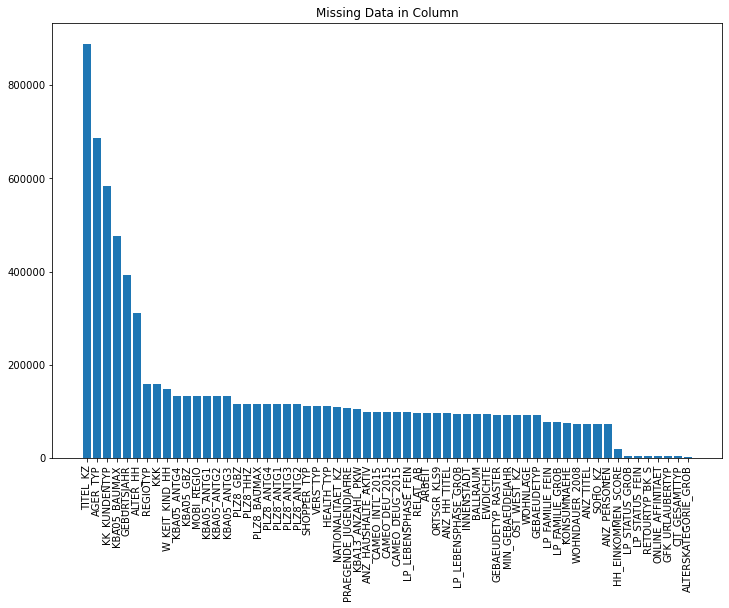

There are 61 columns with missing values.


In [11]:
# Investigate patterns in the amount of missing data in each column.
plt.figure(figsize=(12,8))
plt.xticks(np.arange(len(missingPerColumn)), missingPerColumn.index, rotation='vertical')
plt.bar(missingPerColumn.index, missingPerColumn.values)
plt.title("Missing Data in Column")
plt.show();
print("There are {} columns with missing values.".format(len(missingPerColumn)))

In [12]:
# azdias_missing_row_values
missingData = azdias.isnull().sum(axis = 1)
missingData = missingData[missingData.values > 0].sort_values(ascending=False)
missingData.head()

732775    54
315705    53
708650    53
799836    53
86425     53
dtype: int64

In [13]:
data_outlier = missingPerColumn[missingPerColumn > 200000].index
data_outlier

Index(['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR',
       'ALTER_HH'],
      dtype='object')

In [14]:
missingPerColumn[missingPerColumn > 200000]

TITEL_KZ        889061
AGER_TYP        685843
KK_KUNDENTYP    584612
KBA05_BAUMAX    476524
GEBURTSJAHR     392318
ALTER_HH        310267
dtype: int64

In [15]:
# Remove the outlier columns from the dataset. (You'll perform other data engineering tasks such as re-encoding and imputation later.)
azdias_clean = azdias.drop(columns=data_outlier)

In [16]:
azdias_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

These 6 columns 
- TITEL_KZ
- AGER_TYP
- KK_KUNDENTYP
- KBA05_BAUMAX
- GEBURTSJAHR
- ALTER_HH

are the highest missing data, hence columns that have more than 200k missing data are considered as outlier columns

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [17]:
# How much data is missing in each row of the dataset?
azdias_clean[azdias_clean.isnull().sum(axis = 1)>0].shape[0]

268012

In [18]:
azdias_clean.isnull().sum(axis = 1).describe()

count    891221.000000
mean          5.649894
std          13.234687
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
dtype: float64

In [19]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
azdias_wo_missing_values = azdias_clean[azdias_clean.isnull().sum(axis = 1) <= 3]
azdias_with_missing_values = azdias_clean[azdias_clean.isnull().sum(axis = 1) > 3]

In [20]:
# Compare the distribution of values for at least five columns where there are no or few missing values, between the two subsets.
len(azdias_clean.loc[:, azdias_clean.isnull().sum() <= 3].columns)

24

In [21]:
print(f'Length of WITHOUT Missing Clean Data: {len(azdias_wo_missing_values)}')
print(f'Length of WITH Missing Clean Data: {len(azdias_with_missing_values)}')

print('Rows WITHOUT missing data : {}, Rows with missing data higher: {}'.format(azdias_wo_missing_values.shape[0],azdias_with_missing_values.shape[0]))

Length of WITHOUT Missing Clean Data: 684502
Length of WITH Missing Clean Data: 206719
Rows WITHOUT missing data : 684502, Rows with missing data higher: 206719


In [22]:
def plot_compare(col):    
    fig,ax =  plt.subplots(1,2, figsize=(14,4), sharey=True)
    ax[0].title.set_text('Without or No Missing Data')
    ax[1].title.set_text('With Missing Data')
    sns.countplot(x = col, data = azdias_wo_missing_values,  ax=ax[0])
    sns.countplot(x = col, data = azdias_with_missing_values, ax=ax[1])

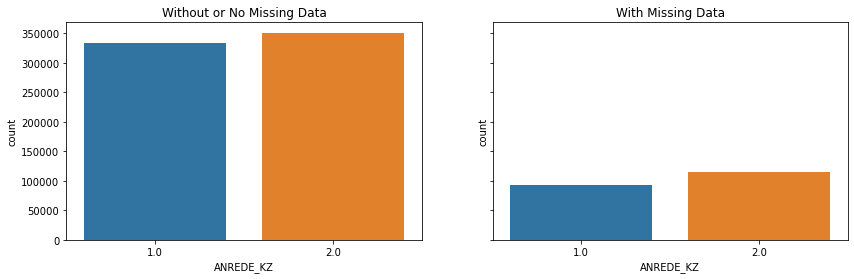

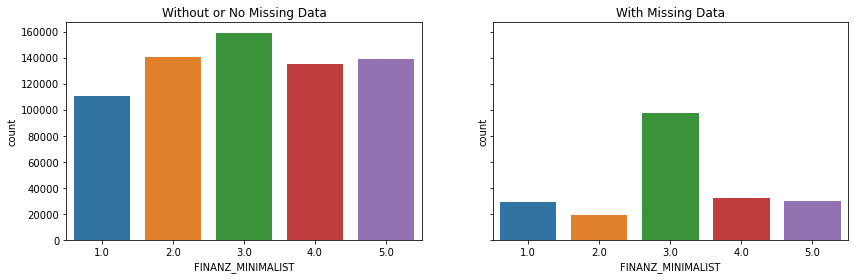

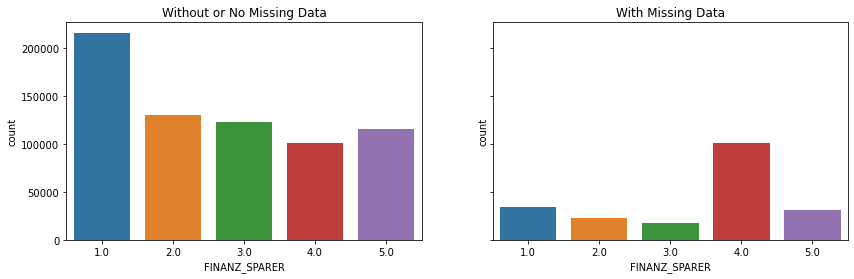

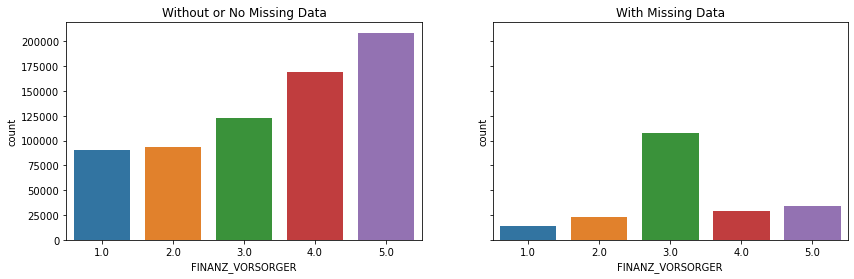

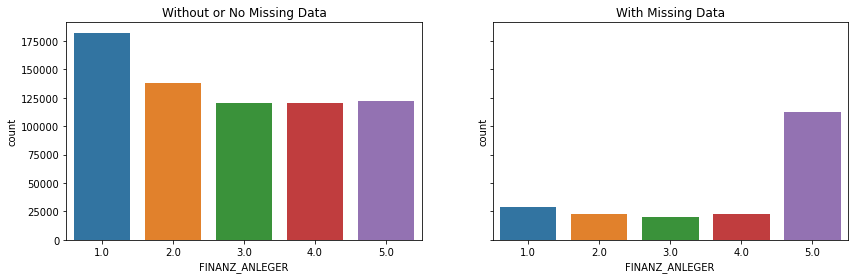

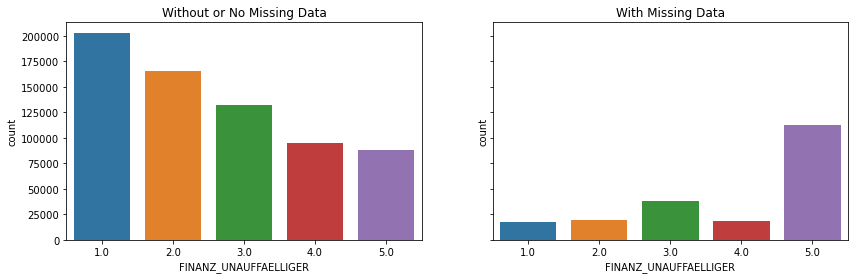

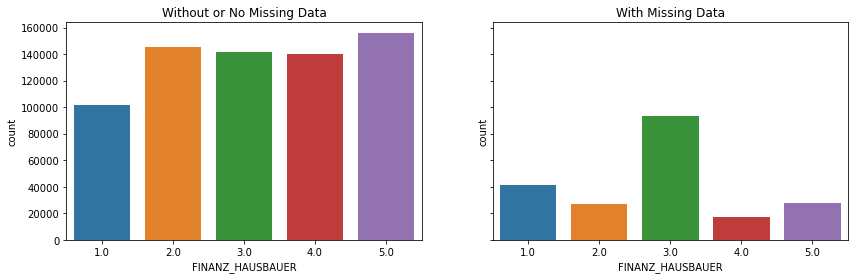

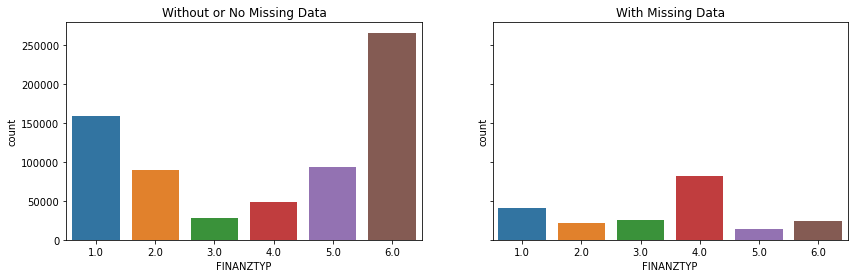

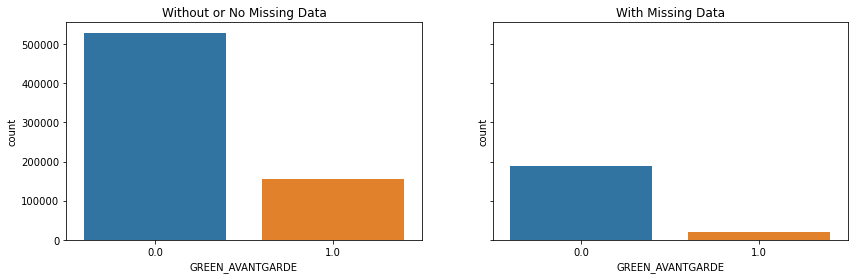

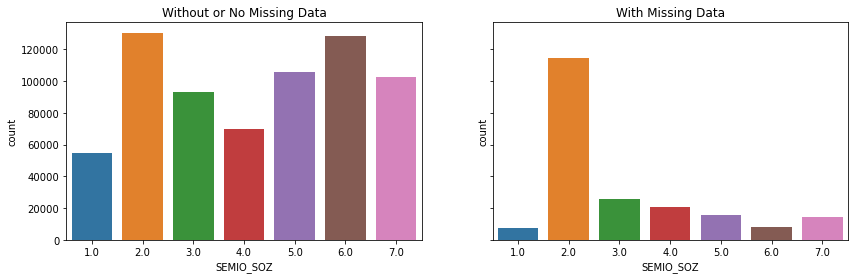

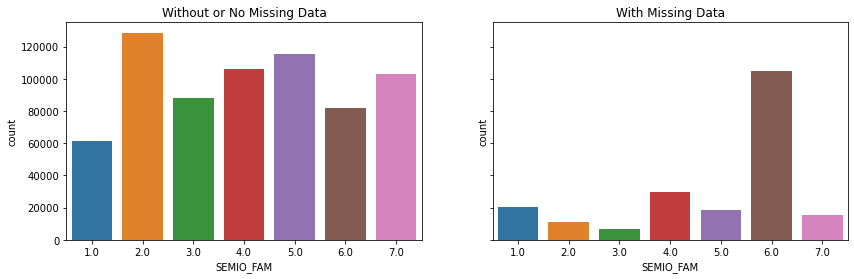

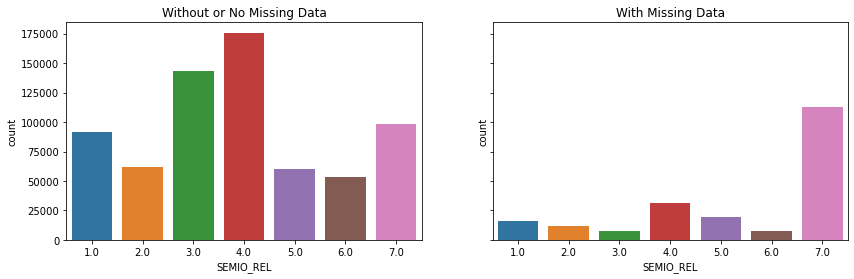

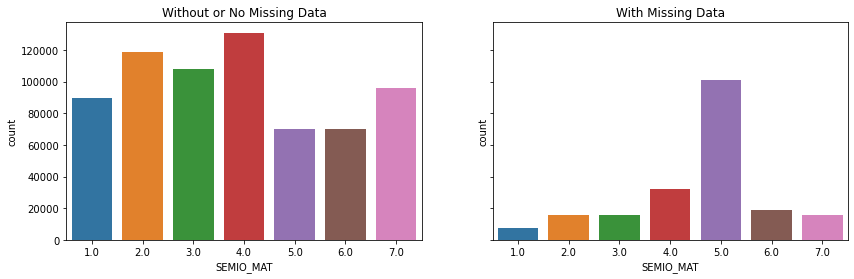

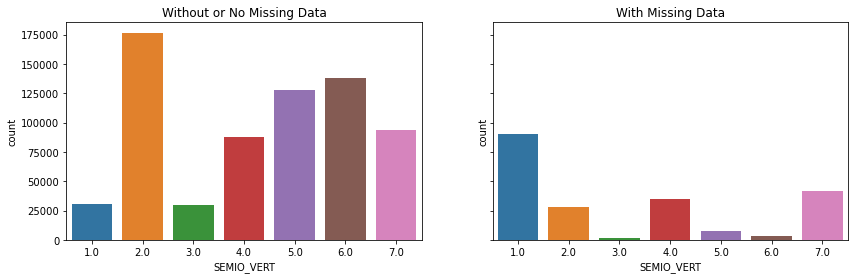

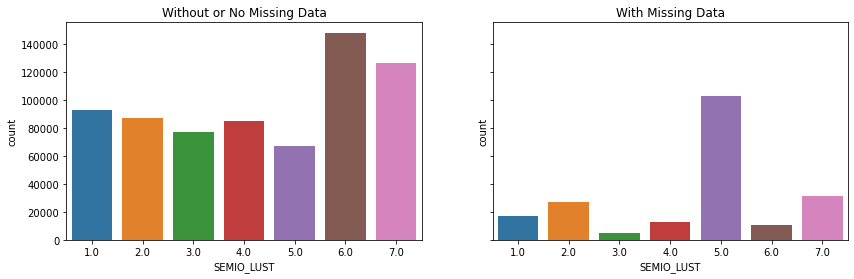

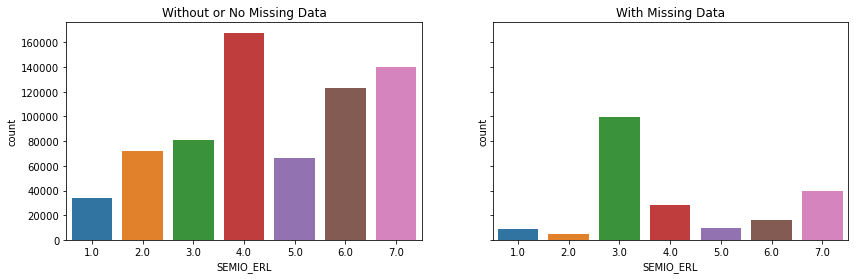

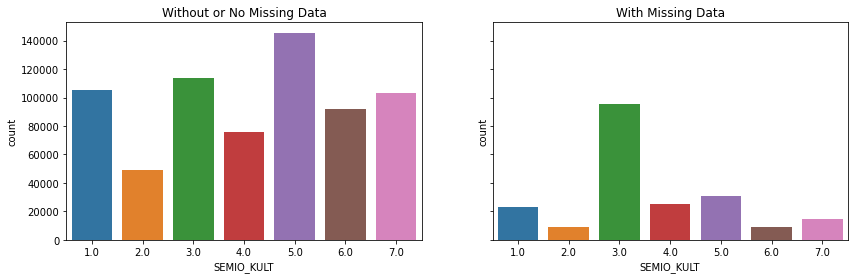

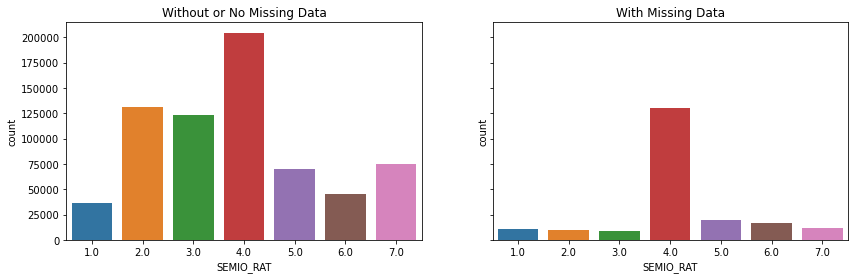

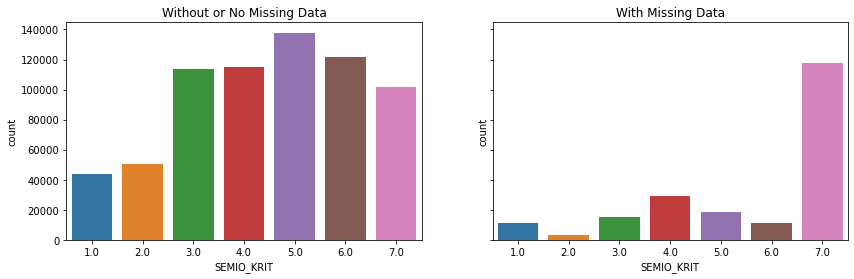

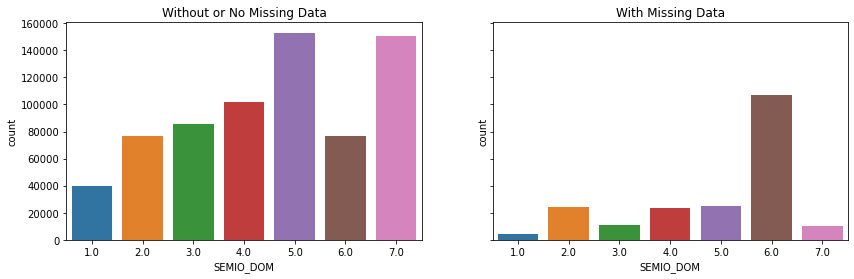

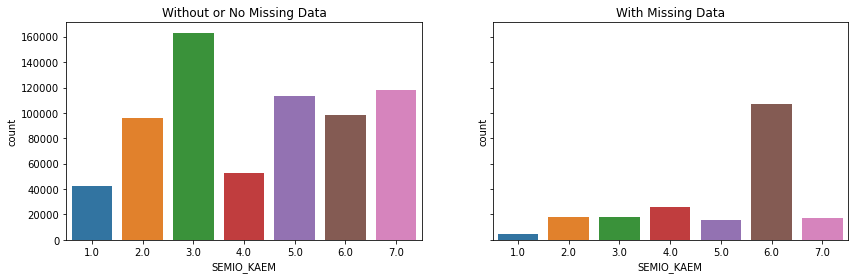

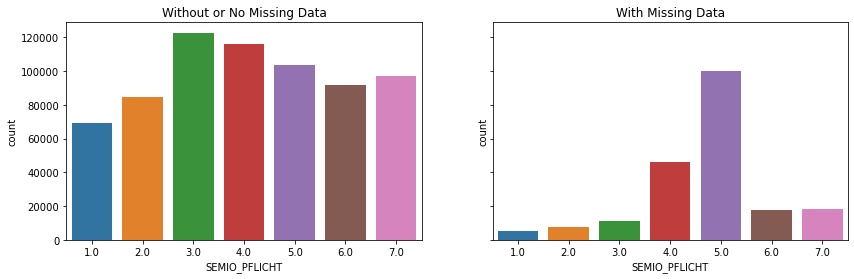

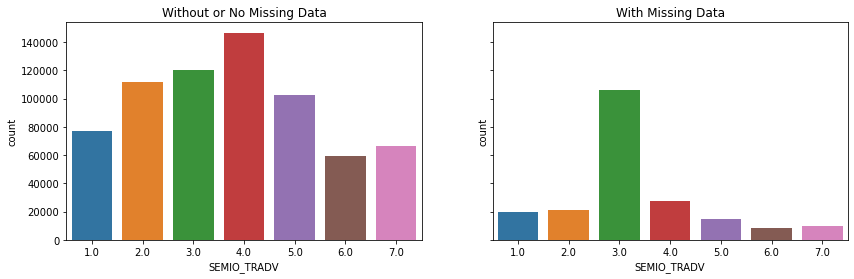

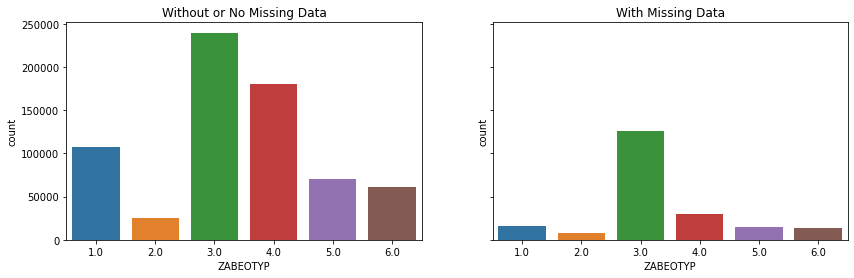

In [23]:
column_list = azdias_clean.loc[:, azdias_clean.isnull().sum() == 0].columns
for columns in column_list:
    plot_compare(columns)

#### Discussion 1.1.3: Assess Missing Data in Each Row

By comparing the rows have missing values with the ones don't have missing values. I found:
    - The datasest with missing values and the one with no or few missing values shared simiarly distributions on these binary columns 
    - The two datasets have different distributions on these non-binary columns
    
Therefore, I decide not remove the rows with many missing values becuase the data distributions will change if remove these values. And may impact on final results.

In [24]:
# Use the dataset with no or few missing values for the further analysis
azdias_clean = azdias_wo_missing_values

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [25]:
# How many features are there of each data type?
feat_info['type'].value_counts()

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [26]:
# Assess categorical variables: which are binary, which are multi-level & which one needs to be re-encoded?
cat_columns = feat_info.loc[(feat_info['type']== 'categorical') & (~feat_info['attribute'].isin(data_outlier))\
              , 'attribute'].values
print(cat_columns)

['ANREDE_KZ' 'CJT_GESAMTTYP' 'FINANZTYP' 'GFK_URLAUBERTYP'
 'GREEN_AVANTGARDE' 'LP_FAMILIE_FEIN' 'LP_FAMILIE_GROB' 'LP_STATUS_FEIN'
 'LP_STATUS_GROB' 'NATIONALITAET_KZ' 'SHOPPER_TYP' 'SOHO_KZ' 'VERS_TYP'
 'ZABEOTYP' 'GEBAEUDETYP' 'OST_WEST_KZ' 'CAMEO_DEUG_2015' 'CAMEO_DEU_2015']


In [27]:
len(cat_columns) - len(azdias_clean.loc[:, cat_columns].describe().columns)

3

In [28]:
azdias_clean.loc[:, cat_columns].describe().columns

Index(['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP',
       'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB',
       'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP',
       'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP'],
      dtype='object')

In [29]:
azdias_clean.loc[:, cat_columns].head()

,ANREDE_KZ,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,GEBAEUDETYP,OST_WEST_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015
1,2.0,5.0,1.0,10.0,0.0,5.0,3.0,2.0,1.0,1.0,3.0,1.0,2.0,5.0,8.0,W,8,8A
2,2.0,3.0,1.0,10.0,1.0,1.0,1.0,3.0,2.0,1.0,2.0,0.0,1.0,5.0,1.0,W,4,4C
4,1.0,5.0,5.0,5.0,0.0,10.0,5.0,3.0,2.0,1.0,2.0,0.0,2.0,4.0,1.0,W,6,6B
5,2.0,2.0,2.0,1.0,0.0,1.0,1.0,4.0,2.0,1.0,0.0,0.0,2.0,4.0,1.0,W,8,8C
6,2.0,5.0,4.0,12.0,0.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,4.0,1.0,W,4,4A


In [30]:
azdias_clean.loc[:, cat_columns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 684502 entries, 1 to 891220
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ANREDE_KZ         684502 non-null  float64
 1   CJT_GESAMTTYP     684502 non-null  float64
 2   FINANZTYP         684502 non-null  float64
 3   GFK_URLAUBERTYP   684502 non-null  float64
 4   GREEN_AVANTGARDE  684502 non-null  float64
 5   LP_FAMILIE_FEIN   684502 non-null  float64
 6   LP_FAMILIE_GROB   684502 non-null  float64
 7   LP_STATUS_FEIN    684502 non-null  float64
 8   LP_STATUS_GROB    684502 non-null  float64
 9   NATIONALITAET_KZ  684502 non-null  float64
 10  SHOPPER_TYP       684502 non-null  float64
 11  SOHO_KZ           684502 non-null  float64
 12  VERS_TYP          684502 non-null  float64
 13  ZABEOTYP          684502 non-null  float64
 14  GEBAEUDETYP       684502 non-null  float64
 15  OST_WEST_KZ       684502 non-null  object 
 16  CAMEO_DEUG_2015   68

In [31]:
# Re-encode categorical variable(s) to be kept in the analysis.
dummies_columns = ['OST_WEST_KZ', 'CAMEO_DEU_2015']
azdias_clean = azdias_clean.join(pd.get_dummies(azdias_clean[dummies_columns], drop_first=True))
azdias_clean['CAMEO_DEUG_2015'] = azdias_clean['CAMEO_DEUG_2015'].astype(float)

In [32]:
azdias_clean.drop(columns = dummies_columns, inplace = True)

#### Discussion 1.2.1: Re-Encode Categorical Features

I used dummy variable instead of doing OneHotEncoded then convert data **CAMEO_DEUG_2015** from string to float and finally encode **OST_WEST_KZ** & **CAMEO_DEU_2015** into dummy variables


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [33]:
feat_info[feat_info['attribute'] == 'PRAEGENDE_JUGENDJAHRE']

,attribute,information_level,type,missing_or_unknown
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1, 0]"


In [34]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
mainstream_list = [1, 3, 5, 8, 10, 12, 14]
w_list = [6, 10, 11]
e_list = [7, 12, 13]
we_list = [1, 2, 3, 4, 5, 8, 9, 14, 15]

#create dominating movement type: 1 for mainstream and 0 for avantgarde
azdias_clean['DOMINATING_MOVEMENT_TYPE_MAINSTREAM'] = \
azdias_clean['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: 1 if x in mainstream_list else 0)

#create dominating movement region: 1 for East, 2 for West and 3 for both East and West
azdias_clean['DOMINATING_MOVEMENT_TYPE_REGION'] = \
azdias_clean['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: 1 if x in e_list else 0)

azdias_clean['DOMINATING_MOVEMENT_TYPE_REGION'] = \
azdias_clean['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: 2 if x in w_list else 0)

azdias_clean['DOMINATING_MOVEMENT_TYPE_REGION'] = \
azdias_clean['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: 3 if x in we_list else 0)

In [35]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
# create wealth type: Wealthy:1, Prosperous: 2, Comfortable: 3, Less Affluent: 4, Poorer: 5, Unknown: NaN
azdias_clean['WEALTH_TYPE'] = \
azdias_clean['CAMEO_INTL_2015'].apply(lambda x: int(int(x)/10) if pd.notnull(x) else x)

# create life stage type: Pre-Family Couples & Singles: 1, Young Couples With Children: 2, 
# Families With School Age Children: 3, Older Families &  Mature Couples: 4, Elders In Retirement: 5, Unknown: NaN
azdias_clean['LIFE_STAGE'] = \
azdias_clean['CAMEO_INTL_2015'].apply(lambda x: int(int(x)%10) if pd.notnull(x) else x)

#### Discussion 1.2.2: Engineer Mixed-Type Features

We have 2 features in our data set that are mixed type features, these are 
- **PRAEGENDE_JUGENDJAHRE** 
- **CAMEO_INTL_2015.** 

Info from data dictionary this DOMINATING_MOVEMENT_TYPE_MAINSTREAM have value as :
- 1 if it was a mainstream movement
- 0 if it is avantgarde movement

Then create code that mainstream movement and check if the code is in the mainstream list.

Created a list of codes that are mainsteam movement and check if the code is in the mainstream list then apply for PRAEGENDE_JUGENDJAHRE into DOMINATING_MOVEMENT_TYPE_MAINSTREAM and DOMINATING_MOVEMENT_TYPE_REGION variables

For CAMEO_INTL_2015 had 2 variables info :
- 1 the wealth level of the household (1-Wealthy, 2-Prosperous, 3-Comfortable 4-Less Affluent, 5-Poorer, -Unknown/NaN)
- 2 the life stage of the household (1-Pre-Family Couples & Singles, 2-Young Couples With Children, 3-Families With School Age Children, 4-Older Families & Mature Couples, 5-Elders In Retirement, Unknown/NaN)

Splited this CAMEO_INTL_2015 into the two new variables. format it by 2 digits and the 10s digit to represents the wealth level meanwhile the digit indicates the life stage.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [36]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
drop_columns = ['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015']
azdias_clean.drop(columns = drop_columns, inplace = True)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [37]:
def clean_data(df):    
    
    # start all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for i in range(feat_info.shape[0]):
        df.loc[df[feat_info.iloc[i,0]].isin(feat_info.iloc[i,-1]), feat_info.iloc[i,0]] =np.nan
            
    # remove selected columns (use data_outlier that defined earlier)
    df = df.drop(columns=data_outlier)
    
    # remove selected rows
    df = df[df.isnull().sum(axis = 1) <=3]
    
    # select, re-encode, and engineer column values.
    dummies_columns = ['OST_WEST_KZ', 'CAMEO_DEU_2015']
    df = df.join(pd.get_dummies(df[dummies_columns], drop_first=True))
    df.drop(columns = dummies_columns, inplace = True)
    
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].astype(float)
    
    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
    mainstream_list = [1, 3, 5, 8, 10, 12, 14]
    w_list = [6, 10, 11]
    e_list = [7, 12, 13]
    we_list = [1, 2, 3, 4, 5, 8, 9, 14, 15]

    #create dominating movement type: 1 for mainstream and 0 for avantgarde
    df['DOMINATING_MOVEMENT_TYPE_MAINSTREAM'] = \
    df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: 1 if x in mainstream_list else 0)

    #create dominating movement region: 1 for East, 2 for West and 3 for both East and West
    df['DOMINATING_MOVEMENT_TYPE_REGION'] = \
    df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: 1 if x in e_list else 0)

    df['DOMINATING_MOVEMENT_TYPE_REGION'] = \
    df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: 2 if x in w_list else 0)

    df['DOMINATING_MOVEMENT_TYPE_REGION'] = \
    df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: 3 if x in we_list else 0)
    
    # Investigate "CAMEO_INTL_2015" and engineer two new variables.
    # wealth type
    df['WEALTH_TYPE'] = \
    df['CAMEO_INTL_2015'].apply(lambda x: int(int(x)/10) if pd.notnull(x) else x)

    # life stage    
    df['LIFE_STAGE'] = \
    df['CAMEO_INTL_2015'].apply(lambda x: int(int(x)%10) if pd.notnull(x) else x)
    
    #drop mixed variables (use drop_columns that defined earlier)
    df = df.drop(columns = drop_columns)        
    
    return df

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [38]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and do that now.
azdias_formated=azdias_clean.columns[azdias_clean.isnull().any()].sort_values(ascending=False)
print(azdias_formated)

Index(['W_KEIT_KIND_HH', 'WEALTH_TYPE', 'RELAT_AB', 'REGIOTYP', 'ORTSGR_KLS9',
       'LP_LEBENSPHASE_GROB', 'LP_LEBENSPHASE_FEIN', 'LIFE_STAGE',
       'KONSUMNAEHE', 'KKK', 'KBA13_ANZAHL_PKW', 'INNENSTADT',
       'GEBAEUDETYP_RASTER', 'EWDICHTE', 'CAMEO_DEUG_2015', 'BALLRAUM',
       'ARBEIT', 'ANZ_HH_TITEL', 'ANZ_HAUSHALTE_AKTIV'],
      dtype='object')


In [39]:
def missing_values_columns_distribution(columns):
    fig,ax =  plt.subplots(1,1)    
    plt.hist(azdias_clean.loc[~azdias_clean[columns].isnull(), columns])
    column_title = 'The Distribution of {}'.format(columns)
    plt.title(column_title)

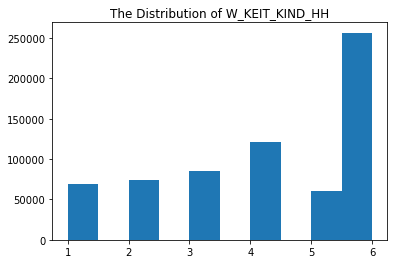

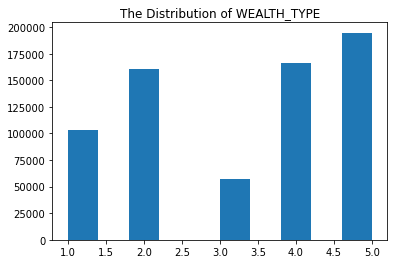

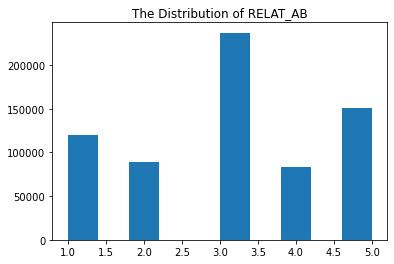

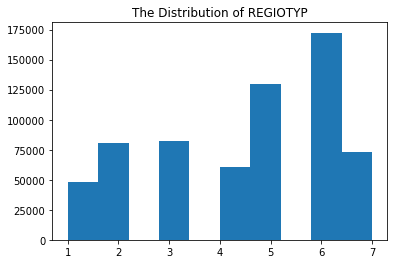

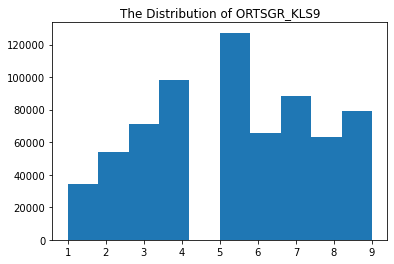

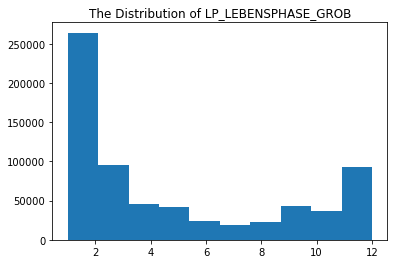

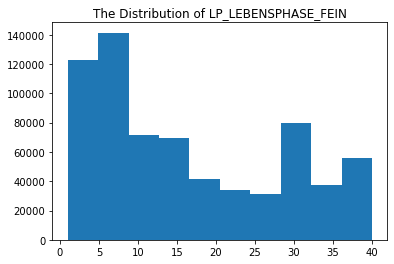

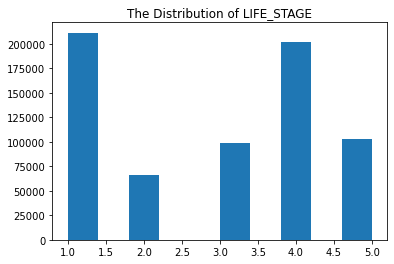

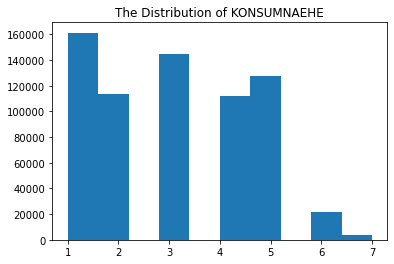

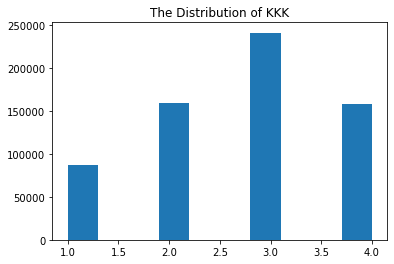

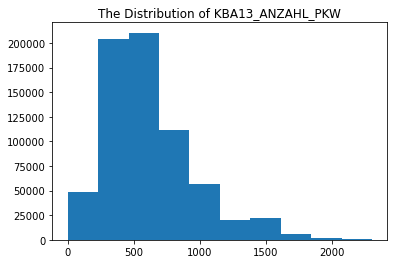

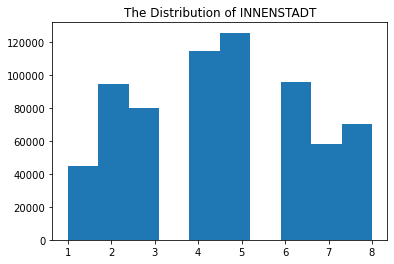

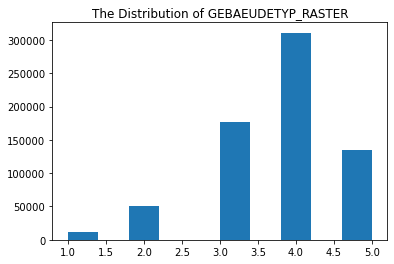

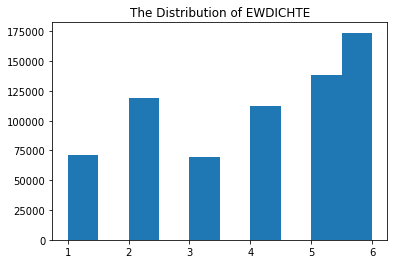

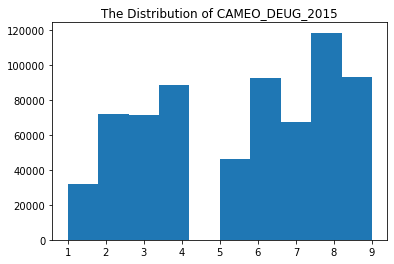

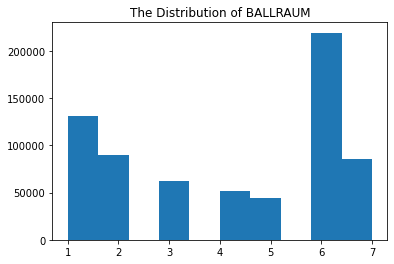

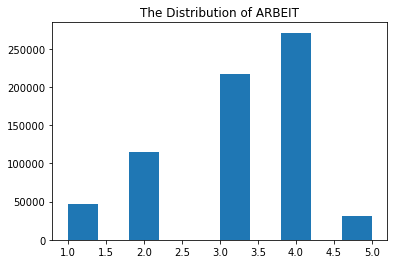

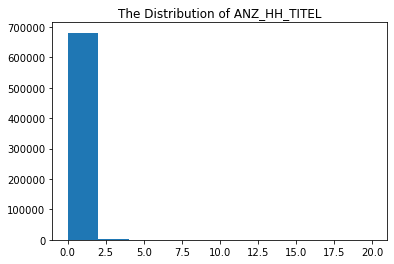

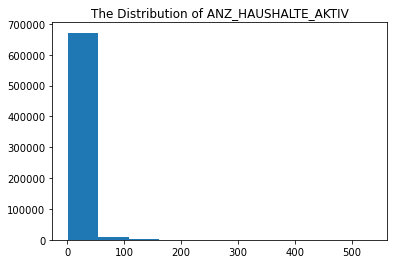

In [40]:
for columns in azdias_formated:
    missing_values_columns_distribution(columns)

In [41]:
# Apply feature scaling to the general population demographics data.
imputer = SimpleImputer(strategy='median')
azdias_imputed = imputer.fit_transform(azdias_clean)

scaler = StandardScaler()
azdias_scaler = scaler.fit_transform(azdias_imputed)

In [42]:
#convert transformed data to a dataframe
azdias_columns = azdias_clean.columns
azdias_clean_final = pd.DataFrame(azdias_scaler, columns = azdias_columns)
azdias_clean_final.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,DOMINATING_MOVEMENT_TYPE_MAINSTREAM,DOMINATING_MOVEMENT_TYPE_REGION,WEALTH_TYPE,LIFE_STAGE
0,-1.747634,0.975423,1.009256,-1.523655,1.588878,-1.050212,1.513292,1.048651,1.341142,-1.399505,...,-0.153788,-0.162991,-0.192113,-0.17991,-0.193076,-0.084106,0.558311,0.567789,1.174934,-1.264621
1,0.193497,0.975423,-0.301300,-1.523655,0.908468,-1.771419,-0.548762,0.320698,1.341142,-1.399505,...,-0.153788,-0.162991,-0.192113,-0.17991,-0.193076,-0.084106,-1.791117,0.567789,-0.872392,0.750539
2,0.193497,-1.025197,1.009256,0.677626,0.228057,0.392200,-1.236113,0.320698,-0.834925,0.521758,...,-0.153788,-0.162991,-0.192113,-0.17991,-0.193076,-0.084106,0.558311,0.567789,0.492492,0.078819
3,-1.747634,0.975423,-0.956578,-0.056134,-1.132765,1.113406,-0.548762,-0.407255,1.341142,-0.919189,...,-0.153788,-0.162991,-0.192113,-0.17991,-0.193076,-0.084106,0.558311,0.567789,1.174934,0.750539
4,-0.777068,0.975423,1.009256,-1.523655,1.588878,-1.771419,1.513292,1.048651,-0.109569,0.041442,...,-0.153788,-0.162991,-0.192113,-0.17991,-0.193076,-0.084106,0.558311,-1.761217,-0.872392,-0.592901


### Discussion 2.1: Apply Feature Scaling
I used median as the strategy of the computer process. Because the median strategy is more robust to the outliers data.
StandardScaler was imported from sklearn to convert the data to same scale and we will need to scale all the variables to reduce the impact of different scales in the data set
Since we will apply PCA and k-means clustering on the data. Both models are sensitive to the different scales of variables.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [43]:
def train_pca_model(n, df, random_state=123):
    '''
    Training the PCM model
    
    INPUT: 
    n(int): the number of components to train
    df(DataFrame): the dataframe of input data
    
    OUTPUT will 
    pca: the trained pca model
    pca_df: the dataframe with transformed data
    '''
    pca = PCA(n_components=n, random_state = random_state)
    pca_df = pca.fit_transform(df)
    return pca, pca_df

In [44]:
# Investigate the variance accounted for by each principal component.
# Reference from Lesson 4:13 - Interpret PCA Results
def plotting_pca(pca): 
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the trained pca model
    OUTPUT: to display the variance accounted for each principal component and the accumulated total variances
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(12, 8))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=8)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=1, length=14)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

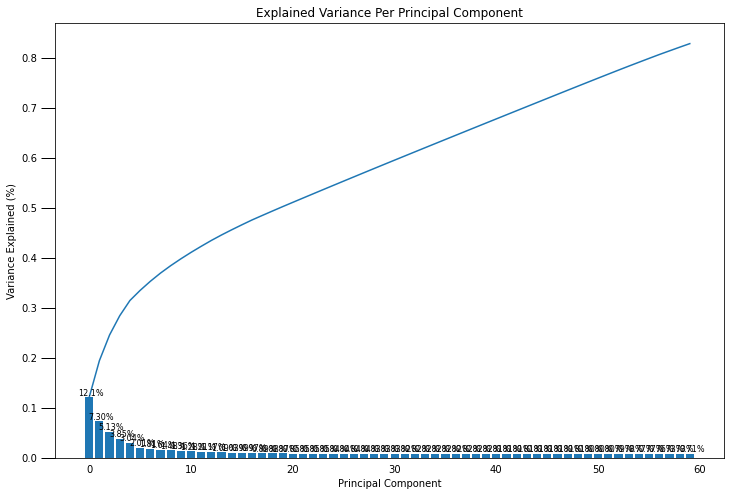

In [45]:
pca, azdias_pca = train_pca_model(60, azdias_clean_final)
plotting_pca(pca)

In [46]:
#generate a name for each component and variances that component explains
n_components_cols = ['PCA{}'.format(i+1) for i in range(pca.components_.shape[0])]
pca_explained_var_df = pd.DataFrame(n_components_cols, columns=['n_components'])
pca_explained_var_df['Explained_Variances'] = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
pca_explained_var_df['Accum_Explained_Variance'] = pca_explained_var_df['Explained_Variances'].cumsum()

#check the accumulated % of each component
pca_explained_var_df['Accum_PCT'] = pca_explained_var_df['Explained_Variances']/\
pca_explained_var_df['Accum_Explained_Variance'].shift(1)

In [79]:
pca_explained_var_df

,n_components,Explained_Variances,Accum_Explained_Variance,Accum_PCT
0,PCA1,0.12,0.12,nan
1,PCA2,0.07,0.19,0.60
2,PCA3,0.05,0.25,0.26
3,PCA4,0.04,0.28,0.16
4,PCA5,0.03,0.31,0.11
5,PCA6,0.02,0.33,0.06
6,PCA7,0.02,0.35,0.05
7,PCA8,0.02,0.37,0.05
8,PCA9,0.01,0.38,0.04
9,PCA10,0.01,0.40,0.04


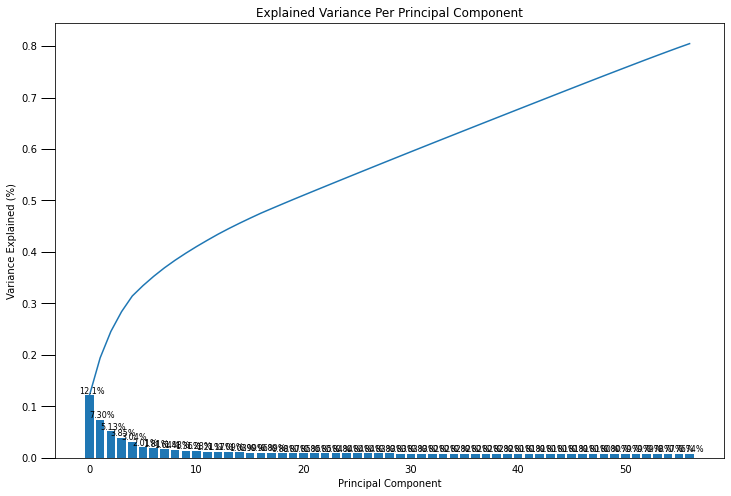

In [48]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca, azdias_pca = train_pca_model(57, azdias_clean_final)
plotting_pca(pca)

In [49]:
#generate dataframe contains pca components data and check the weights of each variables in each components

#generate a name for each component and variances that component explains
n_components_columns = ['PCA{}'.format(i+1) for i in range(pca.components_.shape[0])]

#generate a dataframe contains variables account for each component
pca_components_values = pca.components_.astype('float64')
pca_components_values_df = pd.DataFrame(np.reshape(pca_components_values, (pca_components_values.shape[1], pca_components_values.shape[0])), columns=n_components_columns)

#generate variable names dataframe
pca_var_df = pd.DataFrame(azdias_clean_final.columns, columns=['Variables'])
pca_components_df = pca_var_df.join(pca_components_values_df)

pca_components_df.head()

,Variables,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,...,PCA48,PCA49,PCA50,PCA51,PCA52,PCA53,PCA54,PCA55,PCA56,PCA57
0,ALTERSKATEGORIE_GROB,-0.070582,0.009752,0.022526,-0.181631,0.093371,-0.067252,0.031273,0.035513,0.153901,...,-0.141842,-0.048250,-0.067408,0.194508,-0.200847,0.012571,0.122175,0.133729,-0.191495,-0.100548
1,ANREDE_KZ,0.160642,-0.133860,-0.098795,0.037088,-0.214819,-0.066487,0.060806,-0.066115,-0.194612,...,0.003817,0.013329,0.028772,0.017133,0.012183,0.003406,0.064306,0.044246,0.035476,0.029701
2,CJT_GESAMTTYP,0.036246,0.058471,0.058699,0.058349,0.018477,0.103900,0.016715,0.191673,-0.110778,...,-0.036616,-0.061733,0.007857,0.014306,0.116199,0.063097,0.034041,0.023958,0.001631,-0.035403
3,FINANZ_MINIMALIST,-0.028649,-0.038952,0.028856,-0.036640,-0.009427,0.017924,0.039031,-0.046185,-0.033114,...,-0.010968,0.011076,0.003633,0.003553,-0.002568,-0.005149,0.005684,0.006246,0.024956,0.010867
4,FINANZ_SPARER,-0.008107,0.003499,0.010609,0.009254,0.012062,0.006678,0.004361,0.012779,0.034714,...,-0.215671,-0.259213,-0.301568,-0.326689,-0.080868,-0.091774,-0.122116,0.000327,0.025748,-0.071020


### Discussion 2.2: Perform Dimensionality Reduction

The plot tells us that select 60 components we can preserce more than 80% of the total variance of the data. Therefore, I choose to keep 57 componets.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [50]:
def pca_weights(pca_column, n=5):
    '''
    INPUT: 
    pca_column(string): The column of PCA that needs to check
    n(int): the number of variables need to keep in the output dataframes
    
    OUTPUT: 
    top_weights_df(DataFrame): a dataframe contains the top 5 variables and associated weights
    bottom_weights_df(DataFrame): a dataframe contains the bottom variables and associated weights
    '''
    
    pca_n_df = pca_components_df.loc[:,['Variables', pca_column]].sort_values(by=[pca_column], ascending = False)
    data_top_bottom_df = pd.concat([pca_n_df.head(n), pca_n_df.tail(n).sort_values(by=[pca_column])])    
    
    return data_top_bottom_df

In [51]:
first_data_components_df = pca_weights('PCA1')
first_data_components_df

,Variables,PCA1
99,CAMEO_DEU_2015_6A,0.370313
31,SEMIO_DOM,0.300335
22,SEMIO_FAM,0.292662
49,WOHNLAGE,0.271543
105,CAMEO_DEU_2015_7A,0.239275
45,ANZ_HH_TITEL,-0.399721
64,KBA13_ANZAHL_PKW,-0.272262
92,CAMEO_DEU_2015_4E,-0.204053
14,LP_LEBENSPHASE_GROB,-0.196898
62,ONLINE_AFFINITAET,-0.173353


In [52]:
second_data_components_df = pca_weights('PCA2')
second_data_components_df

,Variables,PCA2
75,OST_WEST_KZ_W,0.611351
12,HEALTH_TYP,0.456725
73,ORTSGR_KLS9,0.446098
28,SEMIO_KULT,0.286707
39,ANZ_PERSONEN,0.180881
49,WOHNLAGE,-0.285056
103,CAMEO_DEU_2015_6E,-0.228714
33,SEMIO_PFLICHT,-0.172837
45,ANZ_HH_TITEL,-0.171275
113,CAMEO_DEU_2015_8D,-0.153438


In [53]:
third_data_components_df = pca_weights('PCA3')
third_data_components_df

,Variables,PCA3
12,HEALTH_TYP,0.380103
88,CAMEO_DEU_2015_4A,0.277275
103,CAMEO_DEU_2015_6E,0.216230
64,KBA13_ANZAHL_PKW,0.185658
39,ANZ_PERSONEN,0.157295
114,CAMEO_DEU_2015_9A,-0.252441
116,CAMEO_DEU_2015_9C,-0.213186
75,OST_WEST_KZ_W,-0.211385
90,CAMEO_DEU_2015_4C,-0.206343
118,CAMEO_DEU_2015_9E,-0.199452


### Discussion 2.3: Interpret Principal Components
I select top 5 & bottom 5 of data components in the first 3 principals. 
All the top components have positive value, means they are positively correlated with other variables and all the bottom components have negative value and there are some negative correlations among the variables.

### Component-1
Social status, Estimated household net income and Wealth are the top 3 factors that are positively correlated. Movement patterns, Number of 1-2 family houses and Financial typology are the top 3 factors that are negatively correlated.


### Component-2

Estimated age based on given name analysis, Financial typology, Energy consumption typology are the top 3 factors that are positively correlated. Dominating movement of person's youth, Personality(religious), Financial typology(money saver) are the top 3 factors that are negatively correlated.

### Component-3

For the third component: Personality typology(dreamful, socially-minded and family-minded) are the top 3 factors that are positively correlated. Personality typology(dominant-minded, combative attitude) and Gender are the top 3 factors that are negatively correlated.


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [54]:
# Over a number of different cluster counts...
num_K = range(1, 30)
distortions = []

for n in num_K:    
    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters = n, random_state=123)
    kmeans = kmeans.fit(azdias_pca)
    
    # compute the average within-cluster distances.
    dist = sum(np.min(cdist(azdias_pca, kmeans.cluster_centers_, 'euclidean'), axis=1)) / azdias_pca.shape[0]
    distortions.append(dist)

Text(0.5, 1.0, 'Plot between K and Distance')

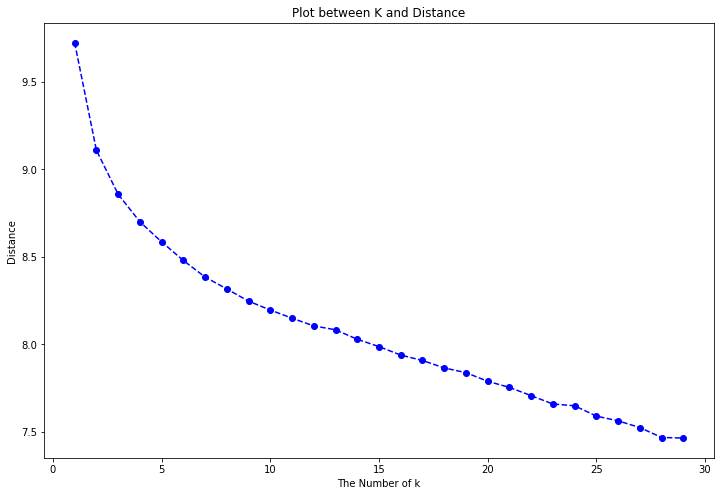

In [55]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.figure(figsize=(12,8))
plt.plot(num_K, distortions, linestyle='--', marker='o', color='b')
plt.xlabel('The Number of k')
plt.ylabel('Distance')
plt.title('Plot between K and Distance')

In [56]:
# Re-fit the k-means model with the selected number of clusters and obtain cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters = 13, random_state=123)
azdias_kmeans_pred = kmeans.fit_predict(azdias_pca)

### Discussion 3.1: Apply Clustering to General Population

Based on visual diagram, it seems slope flattening started from k = 13. Therefore, I pick the 13 clusters to the final model.


### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [57]:
# Apply preprocessing, feature transformation & clustering from the general demographics into the customer data obtaining cluster predictions for the customer demographics data.
customers_clean = clean_data(customer_info)

In [58]:
customers_clean_values = imputer.transform(customers_clean)

In [59]:
customers_clean_values = scaler.transform(customers_clean_values)

In [60]:
customer_columns = customers_clean.columns
customer_clean_final = pd.DataFrame(customers_clean_values, columns = customer_columns)
customer_clean_final.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,DOMINATING_MOVEMENT_TYPE_MAINSTREAM,DOMINATING_MOVEMENT_TYPE_REGION,WEALTH_TYPE,LIFE_STAGE
0,1.164063,-1.025197,1.009256,1.411386,-1.132765,1.113406,-1.236113,-0.407255,-0.834925,-0.919189,...,-0.153788,-0.162991,-0.192113,-0.17991,-0.193076,-0.084106,-1.791117,0.567789,-1.554834,0.078819
1,1.164063,0.975423,-0.956578,1.411386,-1.132765,1.113406,-1.236113,1.048651,0.615786,-0.919189,...,-0.153788,-0.162991,-0.192113,-0.17991,-0.193076,-0.084106,-1.791117,0.567789,-0.189950,0.750539
2,0.193497,-1.025197,1.664534,-0.056134,-1.132765,0.392200,0.825941,1.776603,-0.834925,-0.919189,...,-0.153788,-0.162991,-0.192113,-0.17991,-0.193076,-0.084106,0.558311,0.567789,0.492492,-1.264621
3,0.193497,-1.025197,0.353978,1.411386,-1.132765,1.113406,-1.236113,-0.407255,-0.109569,0.521758,...,-0.153788,-0.162991,-0.192113,-0.17991,-0.193076,-0.084106,-1.791117,0.567789,-0.189950,0.750539
4,1.164063,-1.025197,-0.956578,1.411386,-1.132765,1.113406,-1.236113,-1.135207,-0.834925,-0.919189,...,-0.153788,-0.162991,-0.192113,-0.17991,-0.193076,-0.084106,-1.791117,0.567789,-0.872392,0.078819


In [61]:
customer_pca = pca.transform(customer_clean_final)

In [62]:
customer_kmeans_pred = kmeans.predict(customer_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [63]:
# add cluster data back to the pca data
azdias_clean_final['cluster'] = azdias_kmeans_pred
customer_clean_final['cluster'] = customer_kmeans_pred

In [64]:
pd.options.display.float_format = "{:,.2f}".format

In [65]:
# Compare the proportion of data in each cluster for the customer data to the proportion of data in each cluster for the general population.
# Compare the proportion data of customer vs demographic data
customer_cluster_df = pd.DataFrame(((customer_clean_final['cluster'].value_counts()/customer_clean_final.shape[0])*100))

customer_cluster_df.rename(columns={'cluster':'proportion'}, inplace = True)
customer_cluster_df['cluster'] = customer_cluster_df.index + 1
customer_cluster_df = customer_cluster_df.sort_values(by='cluster')

#get demographic cluster data
azdias_cluster_df = pd.DataFrame((azdias_clean_final['cluster'].value_counts()/azdias_clean_final.shape[0])*100)

azdias_cluster_df.rename(columns={'cluster':'proportion'}, inplace = True)
azdias_cluster_df['cluster'] = azdias_cluster_df.index + 1
azdias_cluster_df = azdias_cluster_df.sort_values(by='cluster')

<AxesSubplot:title={'center':'Demographic Data'}, xlabel='cluster', ylabel='proportion'>

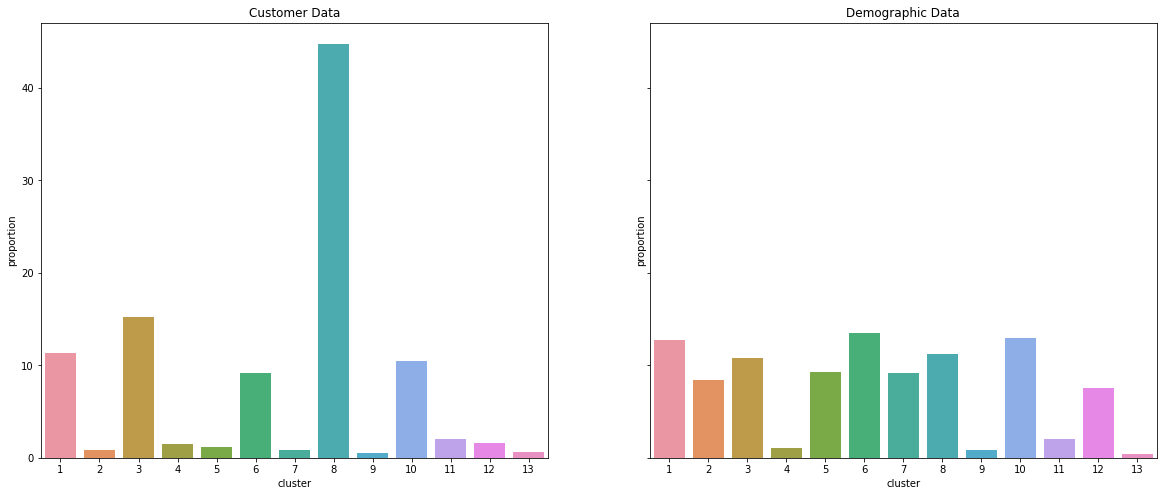

In [66]:
fig,ax =  plt.subplots(1,2, sharey=True, figsize=(20, 8))
ax[0].title.set_text('Customer Data')
ax[1].title.set_text('Demographic Data')
sns.barplot(x = 'cluster', y = 'proportion', data = customer_cluster_df,  ax=ax[0])
sns.barplot(x = 'cluster', y = 'proportion', data = azdias_cluster_df, ax=ax[1])

In [75]:
# Over represented in the customer data compared to the general population?
# check on cluster 8
cluster_overrepresented_values = pca.inverse_transform(kmeans.cluster_centers_[7])
cluster_overrepresented_df = pd.DataFrame(customer_columns, columns = ['column'])
cluster_overrepresented_df['values'] = cluster_overrepresented_values

In [76]:
cluster_overrepresented_df['original_values'] = scaler.inverse_transform(cluster_overrepresented_df['values'].values.reshape(1, 123)).reshape(123, 1)
cluster_overrepresented_df.sort_values(by='values', ascending = False).head()

,column,values,original_values
3,FINANZ_MINIMALIST,1.27,4.81
18,LP_STATUS_GROB,1.20,4.26
17,LP_STATUS_FEIN,1.14,8.76
11,GREEN_AVANTGARDE,1.01,0.65
13,LP_LEBENSPHASE_FEIN,0.98,28.31


In [77]:
# under presented in the customer data compared to the general population?
# on the chart we can see cluster 2,7,9,13
#check on cluster 9
cluster_overreprensented_values = pca.inverse_transform(kmeans.cluster_centers_[8])
cluster_overreprensented_df = pd.DataFrame(customer_columns, columns = ['column'])
cluster_overreprensented_df['values'] = cluster_overreprensented_values

In [78]:
cluster_overreprensented_df['original_values'] = scaler.inverse_transform(cluster_overreprensented_df['values'].values.reshape(1, 123)).reshape(123, 1)
cluster_overreprensented_df.sort_values(by='values', ascending = False).head()

,column,values,original_values
99,CAMEO_DEU_2015_6A,10.59,0.98
53,KBA05_ANTG3,0.62,1.24
68,PLZ8_ANTG4,0.43,1.01
69,PLZ8_BAUMAX,0.39,2.51
67,PLZ8_ANTG3,0.37,1.96


### Discussion 3.3: Compare Customer Data to Demographics Data

**Over-represented**
The cluster **8** is over-represented in the customer data. The top 5 variables are
- FINANZ_MINIMALIST (4.81) average earners
- LP_STATUS_GROB (4.26) average earners 
- LP_STATUS_FEIN (8.76) average earners just bought new house
- GREEN_AVANTGARDE (0.65) Membership in environmental sustainability as part of youth but not a member of green avantgarde
- LP_LEBENSPHASE_FEIN (28.31) top earner families
 
**Under-represented**
The cluster **9** is under-represented in the customer data. The bottom 5 variables are 

- CAMEO_DEU_2015_6A (0.98) Newly employed
- KBA05_ANTG3 (1.24) lower income family
- PLZ8_ANTG4 (1.01) lower income family
- PLZ8_BAUMAX (2.51) low density in PLZ8 region
- PLZ8_ANTG3 (1.96) lower income family

in cluster under-represented customer clusters the wealth is toward less affluent or poorer households, normally income is low.


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.